# Upload datasets from LEAP Buckets to HuggingFace

In [2]:
# Make a dummy medium sized dataset
import xarray as xr
import dask.array as dsa
import os
import fsspec

target_prefix = "gs://leap-scratch/jbusecke/huggingface_test"

ds = xr.DataArray(dsa.random.random([20, 100, 30, 1000], chunks='auto'), dims= ['x', 'y', 'z', 'time']).to_dataset(name='data_a')
ds

<xarray.Dataset> Size: 480MB
Dimensions:  (x: 20, y: 100, z: 30, time: 1000)
Dimensions without coordinates: x, y, z, time
Data variables:
    data_a   (x, y, z, time) float64 480MB dask.array<chunksize=(20, 100, 30, 279), meta=np.ndarray>

In [9]:
# write the datasets to the leap scratch buckets as multiple netcdfs
# Does not work with writing directly to the bucket (see https://github.com/pydata/xarray/issues/4122)
import gcsfs
import fsspec
fs = gcsfs.GCSFileSystem()
fs_local = fsspec.filesystem('local')


n_split = 200
splits = [slice(i,i+n_split) for i in range(0,len(ds.time), n_split)]
datasets = [ds.isel(time=split) for split in splits]
filenames = [f"file_{i}.nc" for i in range(len(datasets))]
file_target = os.path.join(target_prefix, 'multiple_nc_files')
for filename, ds_split in zip(filenames, datasets):
    # write to local
    ds_split.to_netcdf('./'+filename)
    
    # move to bucket
    fs.put_file(filename, os.path.join(file_target, filename))
    fs_local.rm(filename)
    print(filename)

file_0.nc
file_1.nc
file_2.nc
file_3.nc
file_4.nc


In [11]:
# Upload files to the hf hub
# I logged into huggingface in the CLI (huggingface-cli login) and authenticated with a token with write permissions
from huggingface_hub import HfApi
api = HfApi()

for filename, ds_split in zip(filenames, datasets):
    # write to local
    ds_split.to_netcdf('hf_'+filename)
    
    # move to bucket
    api.upload_file(
        path_or_fileobj='./hf_'+filename,
        path_in_repo=f"upload_from_local/{filename}",
        repo_id="jbusecke/test_virtualizarr",
        repo_type="dataset",
    )
    fs_local.rm('hf_'+filename)
    print(filename)

file_0.nc
file_1.nc
file_2.nc
file_3.nc
file_4.nc


# TODO:Upload directly from the bucket

## Use virtualizarr to make a local ref to the hf netcdfs

In [8]:
# !pip install git+https://github.com/zarr-developers/VirtualiZarr.git

In [13]:
hf_urls = [f"hf://datasets/jbusecke/test_virtualizarr/upload_from_local/{filename}" for filename in filenames] # create hf fsspec compatible urls as defined in the hf integrations https://huggingface.co/docs/huggingface_hub/en/guides/hf_file_system#integrations
hf_urls

['hf://datasets/jbusecke/test_virtualizarr/upload_from_local/file_0.nc',
 'hf://datasets/jbusecke/test_virtualizarr/upload_from_local/file_1.nc',
 'hf://datasets/jbusecke/test_virtualizarr/upload_from_local/file_2.nc',
 'hf://datasets/jbusecke/test_virtualizarr/upload_from_local/file_3.nc',
 'hf://datasets/jbusecke/test_virtualizarr/upload_from_local/file_4.nc']

In [32]:
from virtualizarr import open_virtual_dataset

vds_list = [open_virtual_dataset(hfu, indexes={}) for hfu in hf_urls]
dsv = xr.concat(vds_list, dim='time', coords='minimal', compat='override')
dsv.virtualize.to_kerchunk('hf_test.json', format='json')
ds_from_virtual = xr.open_dataset('hf_test.json', engine="kerchunk", chunks={})
xr.testing.assert_allclose(ds_from_virtual, ds)

In [33]:
ds_from_virtual

<xarray.Dataset> Size: 480MB
Dimensions:  (x: 20, y: 100, z: 30, time: 1000)
Dimensions without coordinates: x, y, z, time
Data variables:
    data_a   (x, y, z, time) float64 480MB dask.array<chunksize=(20, 100, 30, 200), meta=np.ndarray>

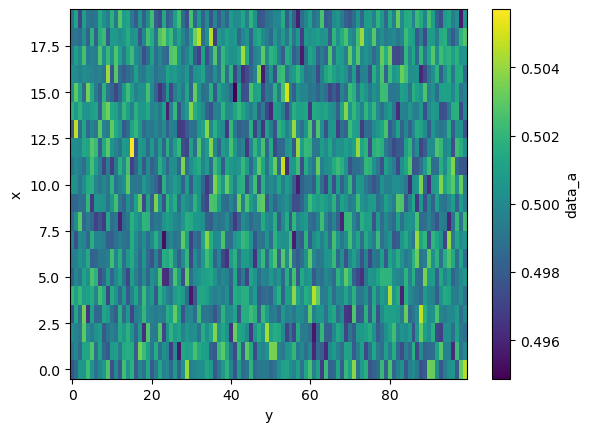

In [29]:
ds_from_virtual.data_a.mean(['time', 'z']).plot()

NIIIICE. This just works!